# Telecom Churn Case Study Hackathon

## Description
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.




## Objective
- It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.
- It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.
- Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives
- The above model will only be able to achieve one of the two goals - to predict customers who will churn. You can’t use the above model to identify the important features for churn. That’s because PCA usually creates components that are not easy to interpret.
- Therefore, build another model with the main objective of identifying important predictor attributes which help the business understand indicators of churn. A good choice to identify important variables is a logistic regression model or a model from the tree family.



In [54]:
import pandas as pd
import numpy as np
from numpy import unique
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


# Common Functions

In [55]:
def col_uniqueness(df):
  unique_df = pd.DataFrame(columns=['col_name','unique_count','unique_percent'])
  for index in range(df.shape[1]):
    unique_count = len(unique(df.iloc[:, index:index + 1]))
    col_unique_percent = round((float(unique_count) / df.shape[0]) * 100,2)
    row_to_append  = pd.DataFrame([{'col_name':df.columns[index],
                            'unique_count':unique_count,
                            'unique_percent': col_unique_percent}])
    unique_df = pd.concat([unique_df, row_to_append])
    #print('%s, %d, %.1f%%' % (df.columns[index], unique_count, col_unique_percent))
  return unique_df

def process_date_col(df):
    print("Dropping columns... \n"
          "last_date_of_month_6, last_date_of_month_7, last_date_of_month_8,"
          "date_of_last_rech_data_6, date_of_last_rech_data_7, date_of_last_rech_data_8 ")
    drop_date_col = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
                     'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']
    df.drop(columns=drop_date_col, inplace=True, axis=1)

    date_type_columns = df.select_dtypes(include=['object']).columns
    print('date_columns {}'.format(date_type_columns))
    for col in date_type_columns:
        df[col] = pd.to_datetime(df[col], format='%m/%d/%Y').dt.day
    print(df[date_type_columns].info())
    return df
def process_int1(df):
    df.drop(columns=['id', 'circle_id'], inplace=True, axis=1)
    return df

def process_int2(df):
    df.drop(columns=['monthly_2g_6','monthly_2g_7','monthly_2g_8',
                     'monthly_3g_6','monthly_3g_7','monthly_3g_8',
                     'sachet_2g_6','sachet_2g_7','sachet_2g_8',
                     'sachet_3g_6','sachet_3g_7','sachet_3g_8'], inplace=True, axis=1)
    return df
def process_float1(df):
    df.drop(columns=['night_pck_user_6',
                     'arpu_2g_6',
                     'fb_user_6',
                     'av_rech_amt_data_6',
                     'total_rech_data_6',
                     'count_rech_3g_6',
                     'max_rech_data_6',
                     'count_rech_2g_6',
                     'arpu_3g_6',
                     'max_rech_data_7',
                     'arpu_2g_7',
                     'arpu_3g_7',
                     'total_rech_data_7',
                     'night_pck_user_7',
                     'count_rech_2g_7',
                     'count_rech_3g_7',
                     'fb_user_7',
                     'av_rech_amt_data_7',
                     'total_rech_data_8',
                     'count_rech_2g_8',
                     'count_rech_3g_8',
                     'arpu_3g_8',
                     'arpu_2g_8',
                     'max_rech_data_8',
                     'av_rech_amt_data_8',
                     'fb_user_8',
                     'night_pck_user_8'], inplace=True, axis=1)
    return df
def process_float2(df):
    df.drop(columns=['loc_og_t2o_mou',
                     'loc_ic_t2o_mou',
                     'std_og_t2o_mou',
                     'std_og_t2c_mou_7',
                     'std_ic_t2o_mou_7',
                     'std_ic_t2o_mou_6',
                     'std_og_t2c_mou_6',
                     'std_og_t2c_mou_8',
                     'og_others_7',
                     'std_ic_t2o_mou_8',
                     'og_others_8',
                     'isd_og_mou_7',
                     'isd_og_mou_8',
                     'isd_og_mou_6',
                     'spl_ic_mou_7',
                     'std_og_t2f_mou_7',
                     'std_og_t2f_mou_8',
                     'std_og_t2f_mou_6',
                     'spl_ic_mou_8',
                     'vol_3g_mb_6',
                     'jun_vbc_3g',
                     'vol_3g_mb_7',
                     'aug_vbc_3g',
                     'vol_3g_mb_8',
                     'jul_vbc_3g',
                     'roam_og_mou_7',
                     'roam_ic_mou_7',
                     'roam_og_mou_8',
                     'roam_ic_mou_8',
                     'isd_ic_mou_6',
                     'isd_ic_mou_8',
                     'isd_ic_mou_7',
                     'og_others_6',
                     'ic_others_7',
                     'loc_og_t2c_mou_6',
                     'roam_og_mou_6',
                     'roam_ic_mou_6',
                     'loc_og_t2c_mou_7',
                     'std_ic_t2f_mou_7',
                     'vol_2g_mb_6',
                     'vol_2g_mb_7',
                     'spl_ic_mou_6',
                     'vol_2g_mb_8',
                     'std_ic_t2f_mou_6',
                     'std_ic_t2f_mou_8',
                     'ic_others_6',
                     'loc_og_t2c_mou_8',
                     'ic_others_8']
            , inplace=True, axis=1)
    return df


def plot_sklearn_roc_curve(y_real, y_preds):
    fpr, tpr, _ = roc_curve(y_real, y_preds)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')


# Load data

In [56]:
telecom_customer_df = pd.read_csv('data/train.csv')
telecom_customer_df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


## Date datatype

In [57]:
date_columns = telecom_customer_df.select_dtypes(include=['object']).columns
print('date columns {}'.format(len(date_columns)))
print(telecom_customer_df.shape)

print("date_of_last_rech_6 is empty by {}%".format(100* round(telecom_customer_df['date_of_last_rech_6'].isna().mean(),2)))
print("date_of_last_rech_7 is empty by {}%".format(100* round(telecom_customer_df['date_of_last_rech_7'].isna().mean(),2)))
print("date_of_last_rech_8 is empty by {}%".format(100*round(telecom_customer_df['date_of_last_rech_8'].isna().mean(),2)))


date columns 9
(69999, 172)
date_of_last_rech_6 is empty by 2.0%
date_of_last_rech_7 is empty by 2.0%
date_of_last_rech_8 is empty by 4.0%


In [58]:
# > ~75% of the data is null for the data recharge, it could be that value is the same as the date of last recharge
# these columns can be dropped

print(100*round(telecom_customer_df['date_of_last_rech_data_6'].isna().mean(),2))
print(100*round(telecom_customer_df['date_of_last_rech_data_7'].isna().mean(),2))
print(100*round(telecom_customer_df['date_of_last_rech_data_8'].isna().mean(),2))


75.0
74.0
74.0


In [59]:
# remove these columns as they only have a single value
display(telecom_customer_df[['last_date_of_month_6']].value_counts())
display(telecom_customer_df[['last_date_of_month_7']].value_counts())
display(telecom_customer_df[['last_date_of_month_8']].value_counts())

last_date_of_month_6
6/30/2014               69999
dtype: int64

last_date_of_month_7
7/31/2014               69600
dtype: int64

last_date_of_month_8
8/31/2014               69266
dtype: int64

In [60]:
telecom_customer_df = process_date_col(telecom_customer_df)
telecom_customer_df.head()

Dropping columns... 
last_date_of_month_6, last_date_of_month_7, last_date_of_month_8,date_of_last_rech_data_6, date_of_last_rech_data_7, date_of_last_rech_data_8 
date_columns Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_of_last_rech_6  68898 non-null  float64
 1   date_of_last_rech_7  68765 non-null  float64
 2   date_of_last_rech_8  67538 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB
None


,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,31.277,87.009,7.527,48.58,124.38,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,0.000,122.787,42.953,0.00,0.00,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,60.806,103.176,0.000,0.53,15.93,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,156.362,205.260,111.095,7.26,16.01,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,240.708,128.191,101.565,21.28,4.83,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


## Int datatype


In [61]:

# Dropping columns that have large number of missing values
#dropping constants and ids
telecom_customer_df = process_int1(telecom_customer_df)
int_columns = telecom_customer_df.select_dtypes(include=['int']).columns
print(telecom_customer_df[int_columns].isna().mean())
print('int columns dont seem to have missing values...')


total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
last_day_rch_amt_6    0.0
last_day_rch_amt_7    0.0
last_day_rch_amt_8    0.0
monthly_2g_6          0.0
monthly_2g_7          0.0
monthly_2g_8          0.0
sachet_2g_6           0.0
sachet_2g_7           0.0
sachet_2g_8           0.0
monthly_3g_6          0.0
monthly_3g_7          0.0
monthly_3g_8          0.0
sachet_3g_6           0.0
sachet_3g_7           0.0
sachet_3g_8           0.0
aon                   0.0
churn_probability     0.0
dtype: float64
int columns dont seem to have missing values...


In [62]:
100*round(telecom_customer_df[int_columns].isin([0]).mean(),2).sort_values(ascending=False)

sachet_3g_8           96.0
sachet_3g_7           96.0
sachet_3g_6           96.0
monthly_3g_8          94.0
monthly_3g_7          94.0
monthly_3g_6          94.0
monthly_2g_6          93.0
monthly_2g_8          93.0
monthly_2g_7          92.0
churn_probability     90.0
sachet_2g_6           87.0
sachet_2g_7           87.0
sachet_2g_8           86.0
last_day_rch_amt_8    34.0
last_day_rch_amt_7    32.0
last_day_rch_amt_6    27.0
max_rech_amt_8        14.0
total_rech_amt_8      14.0
max_rech_amt_7        12.0
total_rech_amt_7      12.0
max_rech_amt_6        11.0
total_rech_amt_6      11.0
total_rech_num_8       4.0
total_rech_num_7       2.0
total_rech_num_6       2.0
aon                    0.0
dtype: float64

In [63]:
# Check Uniqueness of column
col_uniqueness(telecom_customer_df[int_columns]).sort_values(by='unique_count', ascending=True)


,col_name,unique_count,unique_percent
0,churn_probability,2,0.00
0,monthly_2g_6,5,0.01
0,monthly_2g_7,6,0.01
0,monthly_2g_8,6,0.01
0,monthly_3g_6,10,0.01
0,monthly_3g_8,12,0.02
0,monthly_3g_7,13,0.02
0,sachet_3g_6,23,0.03
0,sachet_3g_7,26,0.04
0,sachet_3g_8,28,0.04


In [64]:
#churn_probability is target variable

print(telecom_customer_df[['monthly_2g_6','monthly_2g_7','monthly_2g_8']].isin([0]).mean())
#90% of the monthly_2g_* is zero - dropping the columns
print(telecom_customer_df[['monthly_3g_6','monthly_3g_7','monthly_3g_8']].isin([0]).mean())
#90% of the monthly_3g_* is zero - dropping the columns
print(telecom_customer_df[['sachet_2g_6','sachet_2g_7','sachet_2g_8']].isin([0]).mean())
#80% of the sachet_2g_* is zero - dropping the columns
print(telecom_customer_df[['sachet_3g_6','sachet_3g_7','sachet_3g_8']].isin([0]).mean())
#90% of the sachet_3g_* is zero - dropping the columns

telecom_customer_df = process_int2(telecom_customer_df)

int_columns = telecom_customer_df.select_dtypes(include=['int']).columns
print('len int columns {}'.format(len(int_columns)))

monthly_2g_6    0.927099
monthly_2g_7    0.924227
monthly_2g_8    0.925970
dtype: float64
monthly_3g_6    0.942728
monthly_3g_7    0.943756
monthly_3g_8    0.939856
dtype: float64
sachet_2g_6    0.871184
sachet_2g_7    0.866827
sachet_2g_8    0.859269
dtype: float64
sachet_3g_6    0.958414
sachet_3g_7    0.958599
sachet_3g_8    0.957999
dtype: float64
len int columns 14


## Float datatype

In [65]:
# Drop columns that have large number of missing values
float_columns = telecom_customer_df.select_dtypes(include=['float']).columns
print('len float columns {}'.format(len(float_columns)))
float_na_avg = 100*round(telecom_customer_df[float_columns].isna().mean(),2)
drop_float_columns = float_na_avg.sort_values(ascending=False)\
    .where(lambda avg: avg > 70)\
    .dropna().index.tolist()
drop_float_columns

len float columns 138


['night_pck_user_6',
 'count_rech_3g_6',
 'arpu_2g_6',
 'total_rech_data_6',
 'max_rech_data_6',
 'count_rech_2g_6',
 'arpu_3g_6',
 'fb_user_6',
 'av_rech_amt_data_6',
 'count_rech_3g_7',
 'count_rech_2g_8',
 'count_rech_2g_7',
 'count_rech_3g_8',
 'night_pck_user_7',
 'max_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_7',
 'arpu_3g_7',
 'arpu_3g_8',
 'av_rech_amt_data_7',
 'arpu_2g_7',
 'arpu_2g_8',
 'max_rech_data_8',
 'av_rech_amt_data_8',
 'fb_user_8',
 'fb_user_7',
 'night_pck_user_8']

In [66]:
print("Drop columns above 70% missing values...")
telecom_customer_df = process_float1(telecom_customer_df)
float_columns = telecom_customer_df.select_dtypes(include=['float']).columns
print('len float columns {}'.format(len(float_columns)))


Drop columns above 70% missing values...
len float columns 111


In [67]:
print("Drop columns above 70% zero values...")
float_na_avg = (100*round(telecom_customer_df[float_columns].isin([0]).mean(),2))
drop_float_columns = float_na_avg.sort_values(ascending=False)\
    .where(lambda avg: avg > 70)\
    .dropna().index.tolist()
drop_float_columns


Drop columns above 70% zero values...


['loc_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2o_mou',
 'std_og_t2c_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_6',
 'std_og_t2c_mou_7',
 'og_others_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_8',
 'og_others_8',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'isd_og_mou_6',
 'spl_ic_mou_7',
 'vol_3g_mb_7',
 'std_og_t2f_mou_7',
 'vol_3g_mb_6',
 'jun_vbc_3g',
 'vol_3g_mb_8',
 'std_og_t2f_mou_6',
 'jul_vbc_3g',
 'std_og_t2f_mou_8',
 'aug_vbc_3g',
 'spl_ic_mou_8',
 'roam_og_mou_7',
 'roam_ic_mou_7',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_8',
 'isd_ic_mou_8',
 'og_others_6',
 'vol_2g_mb_6',
 'loc_og_t2c_mou_6',
 'vol_2g_mb_7',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'ic_others_7',
 'vol_2g_mb_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'loc_og_t2c_mou_7',
 'spl_ic_mou_6',
 'ic_others_6',
 'std_ic_t2f_mou_8',
 'loc_og_t2c_mou_8',
 'ic_others_8']

In [68]:

telecom_customer_df = process_float2(telecom_customer_df)
float_columns = telecom_customer_df.select_dtypes(include=['float']).columns
# Check Uniqueness of column
float_df = telecom_customer_df[float_columns]
col_uniqueness(float_df).sort_values(by='unique_count', ascending=True)


,col_name,unique_count,unique_percent
0,date_of_last_rech_6,31,0.04
0,date_of_last_rech_8,32,0.05
0,date_of_last_rech_7,32,0.05
0,loc_og_t2f_mou_8,3312,4.73
0,loc_og_t2f_mou_7,3366,4.81
...,...,...,...
0,total_og_mou_6,33135,47.34
0,total_og_mou_7,33195,47.42
0,arpu_8,60194,85.99
0,arpu_7,61425,87.75


In [69]:
print('len float columns {}'.format(len(float_columns)))

len float columns 63


## Imputation of missing values


In [70]:
# Generally, the imputation should be the very first step in any analysis you do.
# Imputation could influence on the correct center and scale to use!

missing_count = (100 * round(telecom_customer_df.isna().mean(), 2)).sort_values(ascending=False).where(
    lambda avg: avg > 0).dropna()

print(missing_count)
# All float values have less than 5% missing values
missing_columns = missing_count.index.tolist()
telecom_customer_df[missing_columns].describe([.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99])


loc_ic_t2t_mou_8       5.0
std_ic_t2t_mou_8       5.0
loc_og_mou_8           5.0
loc_ic_t2f_mou_8       5.0
loc_ic_t2m_mou_8       5.0
loc_og_t2f_mou_8       5.0
spl_og_mou_8           5.0
loc_ic_mou_8           5.0
loc_og_t2m_mou_8       5.0
std_og_t2m_mou_8       5.0
loc_og_t2t_mou_8       5.0
offnet_mou_8           5.0
std_ic_t2m_mou_8       5.0
onnet_mou_8            5.0
std_og_mou_8           5.0
std_ic_mou_8           5.0
std_og_t2t_mou_8       5.0
loc_ic_t2f_mou_6       4.0
loc_ic_t2m_mou_6       4.0
loc_ic_t2m_mou_7       4.0
date_of_last_rech_8    4.0
loc_ic_t2t_mou_7       4.0
loc_ic_mou_7           4.0
loc_ic_t2f_mou_7       4.0
loc_ic_mou_6           4.0
std_ic_t2t_mou_6       4.0
std_ic_t2t_mou_7       4.0
std_ic_t2m_mou_6       4.0
std_ic_t2m_mou_7       4.0
std_ic_mou_6           4.0
std_ic_mou_7           4.0
loc_ic_t2t_mou_6       4.0
spl_og_mou_7           4.0
loc_og_t2m_mou_7       4.0
loc_og_mou_7           4.0
onnet_mou_6            4.0
onnet_mou_7            4.0
o

,loc_ic_t2t_mou_8,std_ic_t2t_mou_8,loc_og_mou_8,loc_ic_t2f_mou_8,loc_ic_t2m_mou_8,loc_og_t2f_mou_8,spl_og_mou_8,loc_ic_mou_8,loc_og_t2m_mou_8,std_og_t2m_mou_8,...,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_mou_6,std_og_mou_7,spl_og_mou_6,date_of_last_rech_7,date_of_last_rech_6
count,66296.000000,66296.000000,66296.000000,66296.000000,66296.000000,66296.000000,66296.000000,66296.000000,66296.000000,66296.000000,...,67231.000000,67231.000000,67312.000000,67231.000000,67312.000000,67231.000000,67312.000000,67231.000000,68765.000000,68898.000000
mean,47.256388,9.910217,140.476486,11.716763,108.154731,3.661652,5.045027,167.136761,91.121447,90.586999,...,143.893585,80.619382,83.775851,88.152110,91.538615,169.900601,176.401217,3.958619,25.505708,24.128131
std,141.249368,54.248186,245.342359,38.606895,166.223461,13.009193,17.708507,249.288410,152.997805,270.032002,...,252.034597,255.098355,266.693254,255.771554,267.532089,392.046600,409.299501,15.854529,5.765762,6.134773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,5.000000
10%,0.000000,0.000000,0.800000,0.000000,3.010000,0.000000,0.000000,6.390000,0.160000,0.000000,...,0.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,14.000000
20%,1.800000,0.000000,10.590000,0.000000,12.880000,0.000000,0.000000,23.330000,5.790000,0.000000,...,10.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,18.000000
30%,5.090000,0.000000,24.730000,0.000000,25.390000,0.000000,0.000000,43.010000,14.590000,0.000000,...,24.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,22.000000
40%,9.710000,0.000000,41.880000,0.150000,40.240000,0.000000,0.000000,65.960000,25.760000,0.050000,...,42.740000,0.000000,0.000000,0.430000,0.230000,2.940000,2.580000,0.000000,26.000000,25.000000
50%,16.040000,0.000000,63.520000,0.930000,58.210000,0.000000,0.000000,93.890000,40.350000,3.300000,...,65.190000,0.000000,0.000000,3.980000,3.710000,11.730000,11.260000,0.000000,27.000000,27.000000


In [71]:
y = telecom_customer_df.pop("churn_probability")
print("length of the target variable {}".format(len(y)))


length of the target variable 69999


In [72]:
telecom_customer_df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_t2t_mou_6,...,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,2.23,...,65,65,10,22.0,10.0,24.0,65,65,0,1958
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0,145,50,12.0,10.0,26.0,0,0,0,710
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.53,...,70,70,0,11.0,22.0,24.0,70,50,0,882
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,6.99,...,110,110,50,15.0,21.0,25.0,110,110,50,982
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,10.16,...,50,41,30,25.0,26.0,30.0,25,10,30,647


In [73]:
# If the data has a large number of outliers go for the mode value for Imputation else go for mean
# Alternatively, the MICE (Multiple Imputation by Chained Equations) algorithm can also be used - useful only when working with multivariate data

imp = IterativeImputer(estimator=LinearRegression(),
                       missing_values=np.nan,
                       max_iter=5,
                       verbose=2,
                       imputation_order='roman',
                      min_value = telecom_customer_df.min().tolist(),
                       random_state=0)
tc_imputed_df = imp.fit_transform(telecom_customer_df)
# for test dataset run imp.transform(telecom_customer_df_test)


[IterativeImputer] Completing matrix with shape (69999, 76)
[IterativeImputer] Ending imputation round 1/5, elapsed time 9.59
[IterativeImputer] Change: 877.775152009664, scaled tolerance: 45.32 
[IterativeImputer] Ending imputation round 2/5, elapsed time 19.19
[IterativeImputer] Change: 374.9817599816656, scaled tolerance: 45.32 
[IterativeImputer] Ending imputation round 3/5, elapsed time 28.82
[IterativeImputer] Change: 300.14399618176043, scaled tolerance: 45.32 
[IterativeImputer] Ending imputation round 4/5, elapsed time 38.22
[IterativeImputer] Change: 215.900757983619, scaled tolerance: 45.32 
[IterativeImputer] Ending imputation round 5/5, elapsed time 47.45
[IterativeImputer] Change: 192.51643137879586, scaled tolerance: 45.32 


E:\apps\python\anaconda3\envs\workspace\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [74]:

tc_imputed_df = pd.DataFrame.from_records(tc_imputed_df)
tc_imputed_df.columns = telecom_customer_df.columns
tc_imputed_df.min()

arpu_6                -2258.709
arpu_7                -1289.715
arpu_8                 -945.808
onnet_mou_6               0.000
onnet_mou_7               0.000
                         ...   
date_of_last_rech_8       1.000
last_day_rch_amt_6        0.000
last_day_rch_amt_7        0.000
last_day_rch_amt_8        0.000
aon                     180.000
Length: 76, dtype: float64

In [75]:
tc_imputed_df.isna().sum()

arpu_6                 0
arpu_7                 0
arpu_8                 0
onnet_mou_6            0
onnet_mou_7            0
                      ..
date_of_last_rech_8    0
last_day_rch_amt_6     0
last_day_rch_amt_7     0
last_day_rch_amt_8     0
aon                    0
Length: 76, dtype: int64

In [76]:
X_train, X_test, y_train, y_test = train_test_split(tc_imputed_df, y, test_size=0.40, random_state = 42, stratify=y)


## Handle Data imbalance

In [77]:


print(Counter(y))
oversample = RandomOverSampler(sampling_strategy=0.5)
# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
print(Counter(y_train_over))
X_train, y_train = X_train_over, y_train_over
X_test_over, y_test_over = oversample.fit_resample(X_test, y_test)
X_test, y_test = X_test_over, y_test_over
print(Counter(y_test_over))


Counter({0: 62867, 1: 7132})
Counter({0: 37720, 1: 18860})
Counter({0: 25147, 1: 12573})


In [78]:
# % of records with 1 on y
display(round(100*(y.sum()/len(y)), 2))
# % of records with 1 on y_train
display(round(100*(y_train_over.sum()/len(y_train_over)), 2))
# % of records with 1 on y_test
display(round(100*(y_test_over.sum()/len(y_test_over)), 2))

10.19

33.33

33.33

## Scaling numerical variables

In [79]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)
y_train = np.array(y_train)


# Applying PCA on the data


In [80]:
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

PCA(random_state=42)

In [81]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

## Making a scree plot for the explained variance


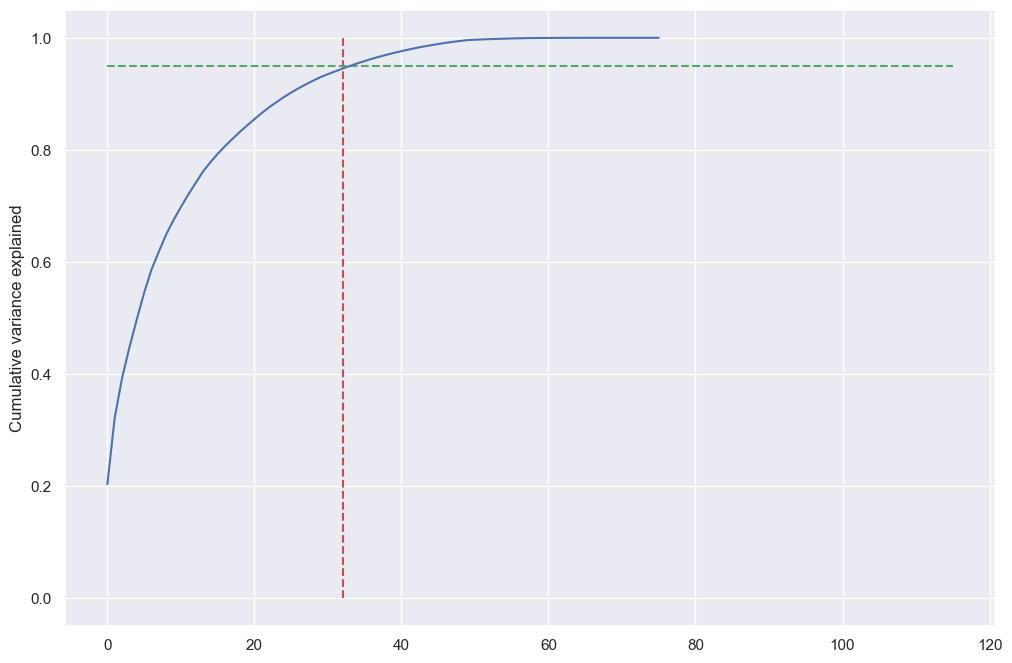

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.202989,0.202989
1,0.321507,0.118517
2,0.392396,0.070889
3,0.447267,0.054872
4,0.496969,0.049701
5,0.544579,0.047610
6,0.586007,0.041428
7,0.618060,0.032053
8,0.648766,0.030706
9,0.674484,0.025718


In [82]:
components_count = 32
fig = plt.figure(figsize=[12, 8])
plt.vlines(x=components_count, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=115, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = var_cumu
pca_df['Explained Variance Ratio'] = pca.explained_variance_ratio_
display(pca_df.head(components_count))


> When we use PCA to reduce our 76 predicting variables to 32 components, we can explain close to 95% of the variance. We can get ignore the remaining variables as it explains only ~5% of the data

We use IncrementalPCA is used to reduce the number of components to 32

In [83]:
pca_final = IncrementalPCA(n_components=components_count)
pca_final.fit(X_train_scaled)
X_train_scaled_pca = pca_final.transform(X_train_scaled)
X_test_scaled_pca = pca_final.transform(X_test_scaled)


In [84]:
# Each component is a linear combination of the original variables with corresponding weights
pca_dimensions = []
for c in range(0, len(pca_df)):
    pca_dimensions.append('PCA Component {}'.format(c))
pca_train_df = pd.DataFrame(pca.components_, columns=tc_imputed_df.columns, index=pca_dimensions)
pca_train_df.head(components_count).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9,...,PCA Component 22,PCA Component 23,PCA Component 24,PCA Component 25,PCA Component 26,PCA Component 27,PCA Component 28,PCA Component 29,PCA Component 30,PCA Component 31
arpu_6,0.170100,-0.054936,-0.038057,-0.052314,-0.095673,-0.213680,-0.069116,0.057209,0.140874,0.060912,...,0.062968,0.039558,0.011492,-0.099376,0.204774,0.017766,0.025486,0.017884,0.124547,0.202075
arpu_7,0.194811,-0.064985,-0.034074,-0.103313,-0.005221,0.017003,-0.059486,0.070689,0.136959,0.107341,...,0.109163,-0.030498,0.032446,-0.162621,0.105097,-0.067728,-0.018903,-0.049703,-0.020315,-0.071071
arpu_8,0.182671,-0.039610,-0.034380,-0.125453,0.084663,0.188537,-0.029798,0.056667,0.104571,0.051347,...,0.078617,0.004153,-0.011912,-0.154793,0.170668,0.026663,-0.000069,0.004324,-0.136529,-0.047277
onnet_mou_6,0.115895,-0.117570,-0.039133,0.198250,0.138550,-0.227355,-0.091629,-0.020524,0.003311,-0.026008,...,0.033598,-0.019514,-0.007081,0.028914,-0.018708,-0.038865,-0.010202,0.034134,-0.129357,-0.068311
onnet_mou_7,0.135036,-0.132455,-0.041349,0.193822,0.233409,-0.062922,-0.084233,-0.031434,-0.034119,-0.039337,...,0.038220,-0.043197,0.031719,-0.048737,-0.027214,-0.045954,-0.011654,-0.067045,0.150091,0.142893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
date_of_last_rech_8,0.051507,-0.042320,0.013625,0.035684,-0.013215,0.160715,0.064942,-0.047822,0.152275,0.113177,...,0.404657,-0.404842,0.083366,-0.012681,0.038559,0.009805,0.012196,0.007232,0.162294,0.144007
last_day_rch_amt_6,0.077895,0.026744,-0.051702,-0.182189,0.048282,-0.128764,-0.144412,0.177158,0.021853,-0.003690,...,0.060070,-0.019522,-0.095749,0.118433,-0.251659,0.000081,-0.019129,0.015430,-0.114063,-0.064315
last_day_rch_amt_7,0.089778,0.022493,-0.046233,-0.179284,0.083620,0.001015,-0.121118,0.150952,0.026211,0.039976,...,-0.244473,0.060828,0.033145,0.244612,-0.204440,0.090630,0.004589,0.059657,0.021992,0.249620
last_day_rch_amt_8,0.082062,0.043598,-0.055622,-0.191504,0.120648,0.046764,-0.112958,0.145076,0.009333,-0.025910,...,-0.124697,0.017108,-0.012258,0.135893,-0.108293,0.004546,0.042250,0.011786,0.169748,0.187363


In [85]:
corrmat = np.corrcoef(X_train_scaled_pca.transpose())
corrmat.shape


(32, 32)

## Plotting the heatmap of the corr matrix


<AxesSubplot: >

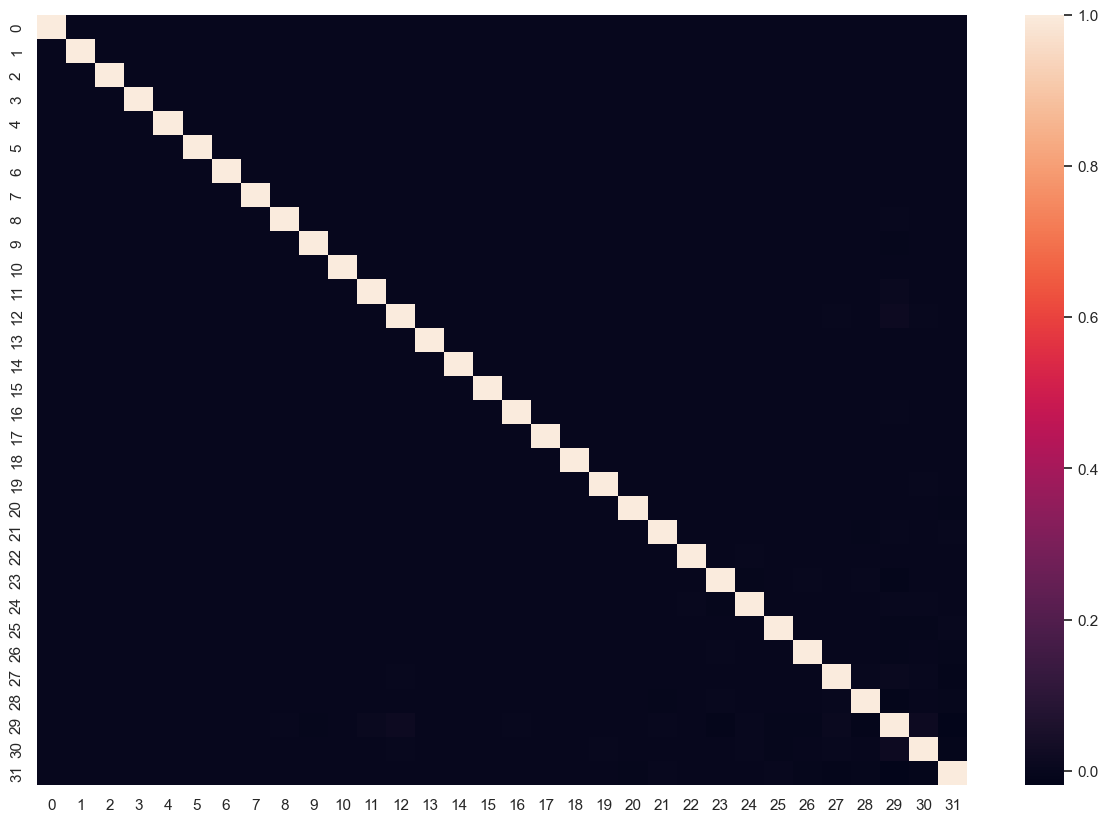

In [86]:
plt.figure(figsize=[15, 10])
sns.heatmap(corrmat, annot=False)
# close to zero correlation

# Using Random Forest on the data on our Principal components


In [87]:
# RandomSearchCV to consider a wide range of values.
# number of trees in our Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 500, num = 5)]
print(n_estimators)
# number of features at each split
max_features = ['log2', 'sqrt']
print(max_features)
# max number of splits each tree can have
max_depth = [int(x) for x in np.linspace(start = 50, stop = 200, num = 5)]
print(max_depth)
# minimum number of observations required before a node of a tree can split itself
min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 150, num = 5)]
print(min_samples_split)
# minimum number of observations required at each leaf at the ends of each tree
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 5)]
print(min_samples_leaf)
# whether to use bootstrapping or not to provide data to each tree in the Random Forest
bootstrap = [True, False]
print(bootstrap)

[25, 143, 262, 381, 500]
['log2', 'sqrt']
[50, 87, 125, 162, 200]
[1, 38, 75, 112, 150]
[1, 13, 25, 37, 50]
[True, False]


In [88]:
# Following hyperparameters to be set

params = {
          'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'bootstrap': bootstrap
          }

CV_rfc = RandomizedSearchCV(estimator=rf,
                            param_distributions=params,
                            n_iter = 15,
                            cv = 4,
                            verbose = 3,
                            n_jobs=-1,
                            scoring="accuracy",
                            random_state=42)

In [89]:
%%time
CV_rfc.fit(X_train_scaled_pca, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
CPU times: total: 2min 31s
Wall time: 3min 30s


RandomizedSearchCV(cv=4,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [50, 87, 125, 162, 200],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 13, 25, 37, 50],
                                        'min_samples_split': [1, 38, 75, 112,
                                                              150],
                                        'n_estimators': [25, 143, 262, 381,
                                                         500]},
                   random_state=42, scoring='accuracy', verbose=3)

In [90]:
display(CV_rfc.best_params_)
# The best_params may not give the best insight at this point to get he best parameters for hyperparameter tuning
# checking the RandomSearchCV results to assess best parameters
rs_df = pd.DataFrame(CV_rfc.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
    'mean_fit_time',
    'std_fit_time',
    'mean_score_time',
    'std_score_time',
    'params',
    'split0_test_score',
    'split1_test_score',
    'split2_test_score',
    'std_test_score'],
    axis=1)
rs_df.head(components_count)


{'n_estimators': 381,
 'min_samples_split': 75,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 87,
 'bootstrap': False}

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,mean_test_score,rank_test_score
0,381,75,1,sqrt,87,False,0.940191,0.937010,1
1,25,38,1,sqrt,200,True,0.939343,0.936939,2
2,25,38,1,sqrt,50,True,0.939343,0.936939,2
3,25,75,1,sqrt,162,False,0.933828,0.931672,4
4,143,112,1,sqrt,200,False,0.917709,0.914016,5
5,25,75,25,sqrt,87,False,0.906893,0.902280,6
6,500,112,13,log2,50,False,0.902227,0.898392,7
7,500,112,13,sqrt,162,False,0.902227,0.898392,7
8,500,112,1,log2,162,True,0.891693,0.888530,9
9,262,38,50,sqrt,50,False,0.887098,0.883192,10


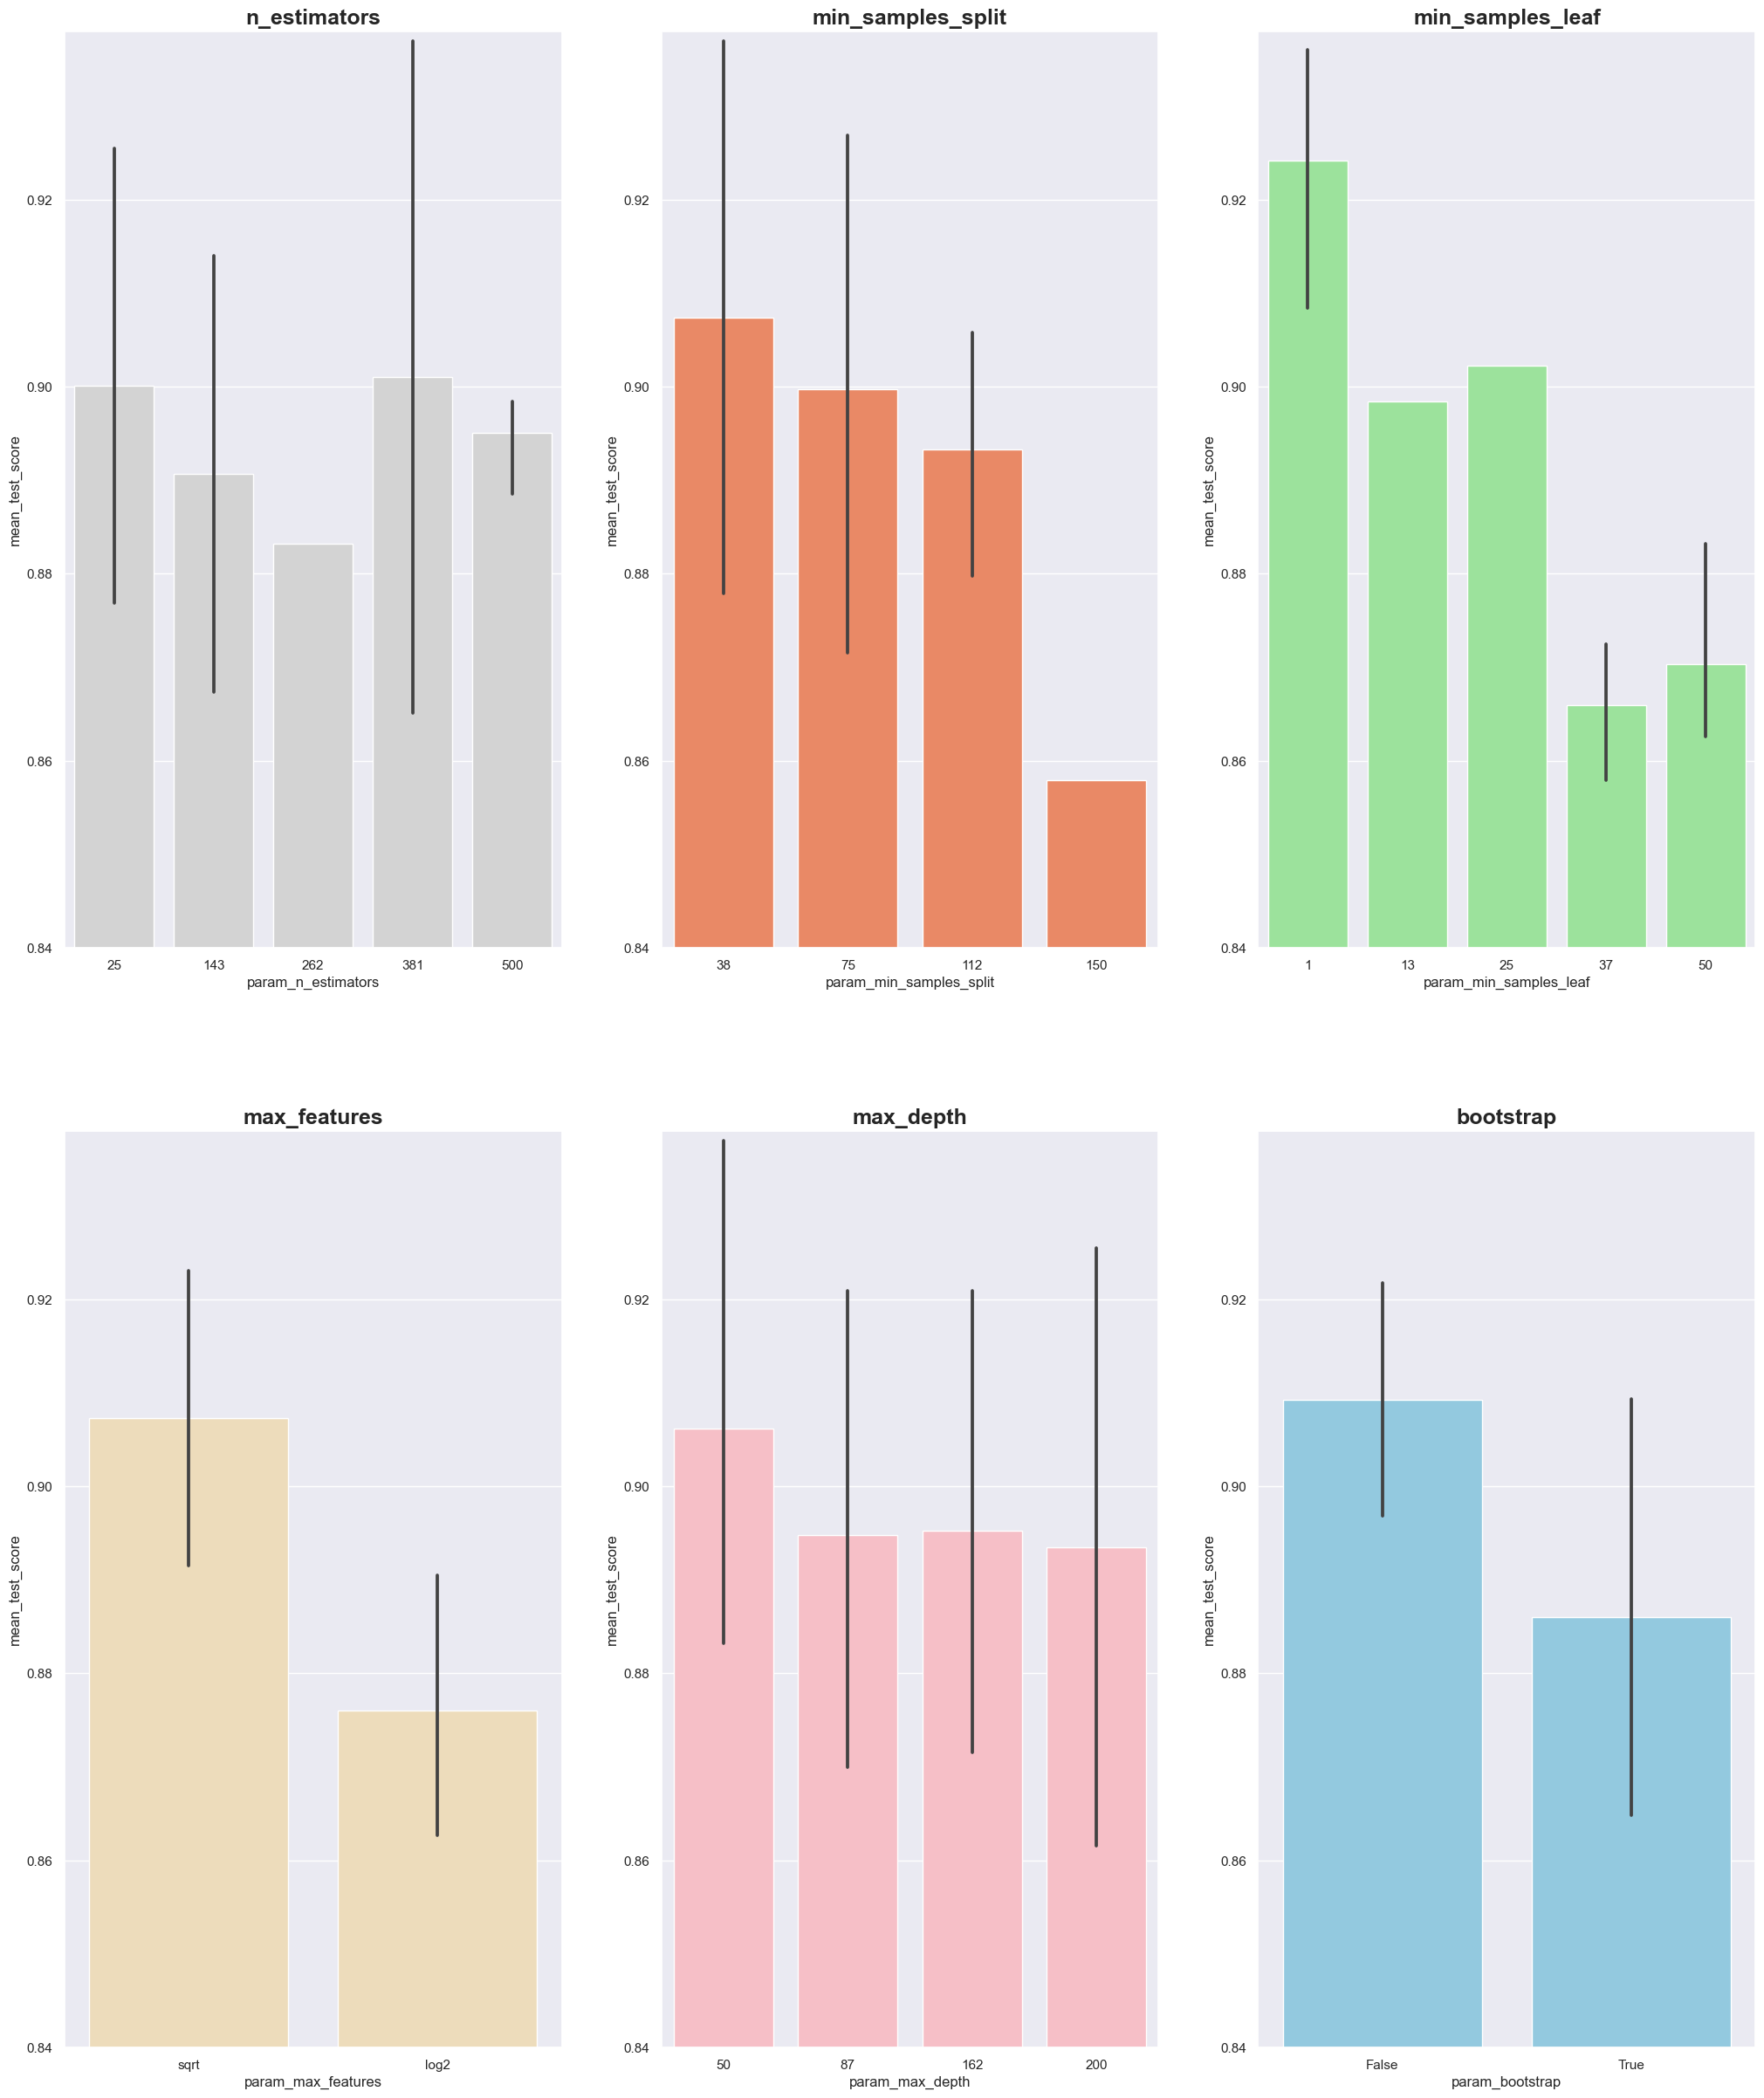

In [91]:
fig, axs = plt.subplots(ncols=3, nrows=2)

sns.set(style="whitegrid", color_codes=True, font_scale = 1)

fig.set_size_inches(25,30)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.84,.938])
axs[0,0].set_title(label = 'n_estimators', size=18, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.84,.938])
axs[0,1].set_title(label = 'min_samples_split', size=18, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.84,.938])
axs[0,2].set_title(label = 'min_samples_leaf', size=18, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.84,.938])
axs[1,0].set_title(label = 'max_features', size=18, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.84,.938])
axs[1,1].set_title(label = 'max_depth', size=18, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.84,.938])
axs[1,2].set_title(label = 'bootstrap', size=18, weight='bold')

plt.show()



## Evaluate Performance Of Models On Test Data

In [92]:
rfc_best=RandomForestClassifier(random_state=42,
                                oob_score=True,
                                max_depth=50 ,
                                max_features='sqrt',
                                min_samples_leaf= 1,
                                min_samples_split= 38,
                                n_jobs=-1,
                                n_estimators=381)
rfc_best.fit(X_train, y_train)
display(rfc_best.oob_score_)

0.9544008483563097

In [93]:
y_test_pred = rfc_best.predict(X_test)
conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
tp = conf_matrix_tuned_pca['predicted 0'][0]
tn = conf_matrix_tuned_pca['predicted 1'][1]
fn = conf_matrix_tuned_pca['predicted 0'][1]
fp = conf_matrix_tuned_pca['predicted 1'][0]

In [94]:
print("Confusion Matrix:")
display(conf_matrix_tuned_pca)
accuracy = (tp+tn)/(tp+fp+tn+fn)
accuracy = np.round(100 * accuracy, 2)

# proportion of true positives (correctly classified as positive) among all positive predictions
precision = np.round(100 * precision_score(y_test, y_test_pred, average='weighted'), 2)
# proportion of true positives among all actual positives.
recall = np.round(100 * recall_score(y_test, y_test_pred, average='weighted'), 2)

# Evaluate the performance of a binary classification model,higher score indicates better performance.
f1_score = np.round(2 * ((precision * recall ) / (precision + recall)),2)
print('Recall score   :', recall)
print('Precision score:', precision)
print('Accuracy score :', accuracy)
print('F1 score :', f1_score)

# how much the model is capable of distinguishing between classes.
print('AUC ROC Curve  :', np.round(100 * roc_auc_score(y_test, y_test_pred) ,2) )


Confusion Matrix:


,predicted 0,predicted 1
actual 0,24384,763
actual 1,4483,8090


Recall score   : 86.09
Precision score: 86.77
Accuracy score : 86.09
F1 score : 86.43
AUC ROC Curve  : 80.66


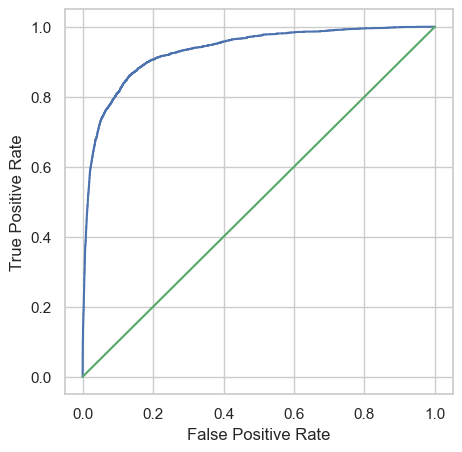

In [95]:

y_test_proba = rfc_best.predict_proba(X_test)
plot_sklearn_roc_curve(y_test, y_test_proba[:, 1])

## Feature Importance

In [96]:
len(rfc_best.feature_importances_)
feature_imp_df = pd.DataFrame({'features':tc_imputed_df.columns, 'Imp':rfc_best.feature_importances_})
feature_imp_df = feature_imp_df.sort_values(by='Imp', ascending=False)
feature_imp_df


,features,Imp
59,total_ic_mou_8,0.119199
35,total_og_mou_8,0.114435
2,arpu_8,0.061247
65,total_rech_amt_8,0.046365
68,max_rech_amt_8,0.043632
...,...,...
30,spl_og_mou_6,0.002573
16,loc_og_t2f_mou_7,0.002340
72,last_day_rch_amt_6,0.002264
42,loc_ic_t2f_mou_6,0.002195


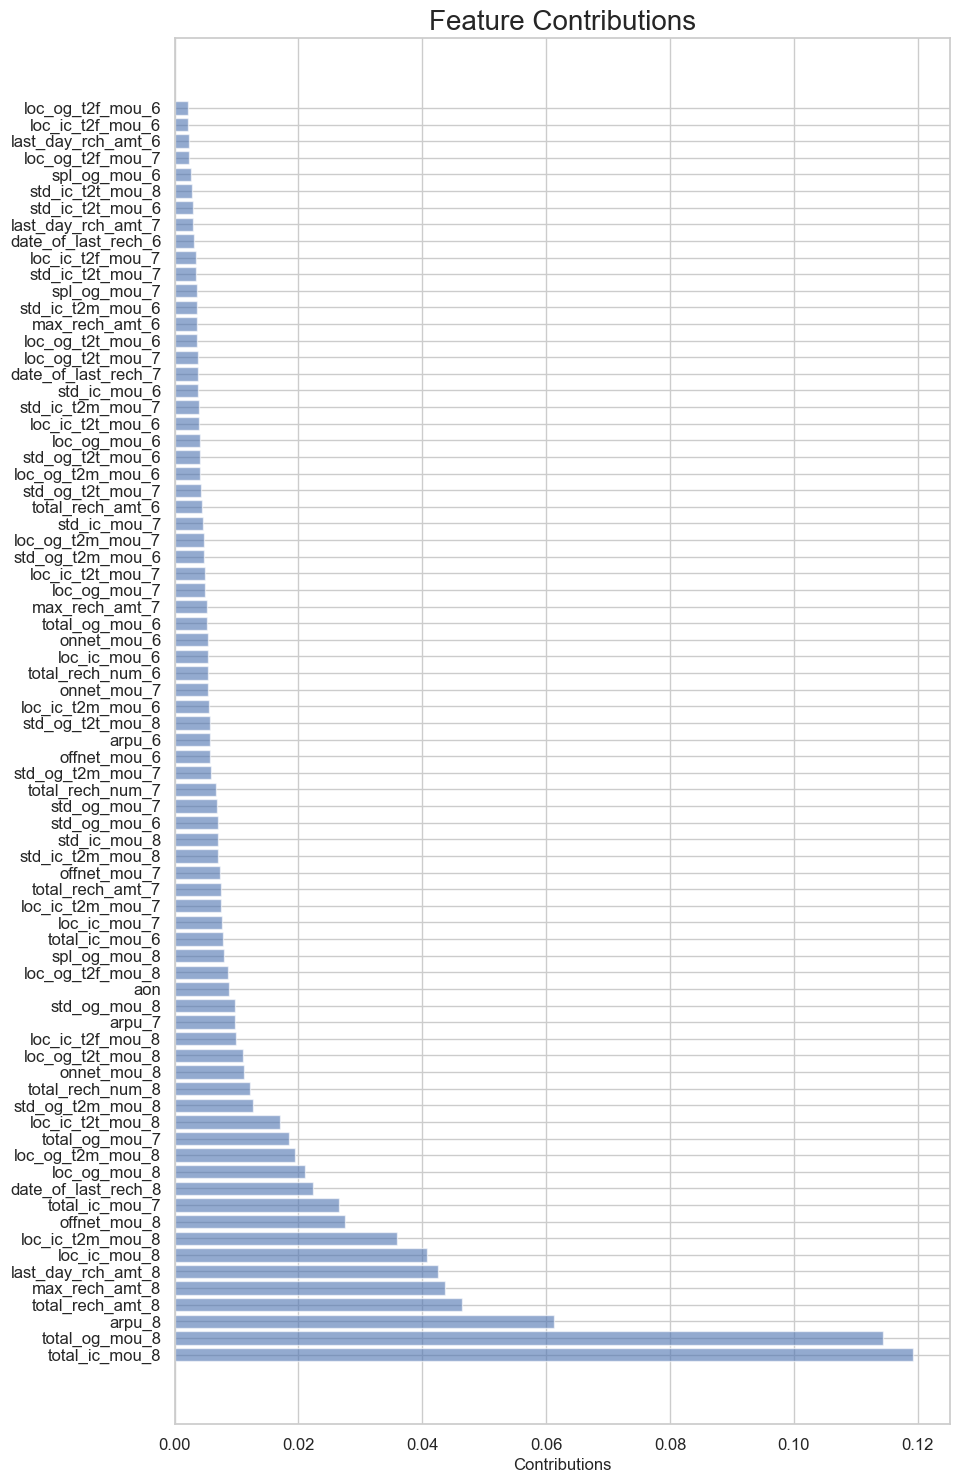

In [97]:
objects = feature_imp_df.features.to_list()
y_pos = np.arange(len(objects))
performance = feature_imp_df.Imp.to_list()
fig, ax = plt.subplots(figsize=(10, 18))
plt.barh(y_pos, performance, align='center', alpha=0.6)
plt.yticks(y_pos, objects,fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Contributions')
plt.title('Feature Contributions',fontsize=20)
plt.show()

### Top 10 features

In [98]:
display(feature_imp_df[0:10])

,features,Imp
59,total_ic_mou_8,0.119199
35,total_og_mou_8,0.114435
2,arpu_8,0.061247
65,total_rech_amt_8,0.046365
68,max_rech_amt_8,0.043632
74,last_day_rch_amt_8,0.042507
47,loc_ic_mou_8,0.040796
41,loc_ic_t2m_mou_8,0.035935
8,offnet_mou_8,0.027489
58,total_ic_mou_7,0.026493


# Prediction on test data

In [99]:
tc_test_df = pd.read_csv('data/test.csv')
tc_test_df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [100]:
print('Apply same treatment to test data...')
id_col = tc_test_df['id']
tc_test_df = process_date_col(tc_test_df)
tc_test_df = process_int1(tc_test_df)
tc_test_df = process_int2(tc_test_df)
tc_test_df = process_float1(tc_test_df)
tc_test_df = process_float2(tc_test_df)

#### Int datatype


Apply same treatment to test data...
Dropping columns... 
last_date_of_month_6, last_date_of_month_7, last_date_of_month_8,date_of_last_rech_data_6, date_of_last_rech_data_7, date_of_last_rech_data_8 
date_columns Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_of_last_rech_6  29494 non-null  float64
 1   date_of_last_rech_7  29467 non-null  float64
 2   date_of_last_rech_8  28839 non-null  float64
dtypes: float64(3)
memory usage: 703.2 KB
None


In [101]:
display(tc_test_df.head())
display(tc_test_df.shape)
tc_test_df.isna().sum()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_t2t_mou_6,...,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon
0,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,24.88,...,50,30,30,21.0,26.0,24.0,30,30,0,1692
1,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,75.51,...,250,250,250,19.0,16.0,24.0,250,0,0,2533
2,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,0.00,...,300,500,500,29.0,27.0,28.0,0,0,0,277
3,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,5.31,...,110,150,0,25.0,30.0,24.0,110,150,0,1244
4,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,0.45,...,90,130,130,29.0,29.0,30.0,50,130,130,462


(30000, 76)

arpu_6                    0
arpu_7                    0
arpu_8                    0
onnet_mou_6            1169
onnet_mou_7            1172
                       ... 
date_of_last_rech_8    1161
last_day_rch_amt_6        0
last_day_rch_amt_7        0
last_day_rch_amt_8        0
aon                       0
Length: 76, dtype: int64

## Imputation of test data

In [102]:
print('Imputation of test data...')
tc_imputed_test_df = imp.transform(tc_test_df)
tc_imputed_test_df = pd.DataFrame.from_records(tc_imputed_test_df)
tc_imputed_test_df.columns = tc_test_df.columns
tc_imputed_test_df.min()

Imputation of test data...
[IterativeImputer] Completing matrix with shape (30000, 76)
[IterativeImputer] Ending imputation round 1/5, elapsed time 0.24
[IterativeImputer] Ending imputation round 2/5, elapsed time 0.46
[IterativeImputer] Ending imputation round 3/5, elapsed time 0.70
[IterativeImputer] Ending imputation round 4/5, elapsed time 0.93
[IterativeImputer] Ending imputation round 5/5, elapsed time 1.17


arpu_6                 -185.043
arpu_7                -2014.045
arpu_8                 -146.859
onnet_mou_6               0.000
onnet_mou_7               0.000
                         ...   
date_of_last_rech_8       1.000
last_day_rch_amt_6        0.000
last_day_rch_amt_7        0.000
last_day_rch_amt_8        0.000
aon                     180.000
Length: 76, dtype: float64

In [103]:
print('No null values in tc_imputed_test_df')
tc_imputed_test_df.isna().sum()

No null values in tc_imputed_test_df


arpu_6                 0
arpu_7                 0
arpu_8                 0
onnet_mou_6            0
onnet_mou_7            0
                      ..
date_of_last_rech_8    0
last_day_rch_amt_6     0
last_day_rch_amt_7     0
last_day_rch_amt_8     0
aon                    0
Length: 76, dtype: int64

## Prediction

In [107]:
print('Prediction of test data...')
y_test_pred = rfc_best.predict(tc_imputed_test_df)

Prediction of test data...


In [108]:
display(y_test_pred.shape)
display(id_col.shape)

(30000,)

(30000,)

In [106]:
submission_df = pd.DataFrame({'id':id_col.values.tolist(),'churn_probability':y_test_pred.tolist()})
# save file for Submission
submission_df.to_csv('Submission.csv', index=False)

100*submission_df['churn_probability'].sum()/len(submission_df['churn_probability'])

9.646666666666667